In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

from utils import mnist
import numpy as np

In [2]:
def plot_train_test(logs, tpe='loss'):
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for index, log in enumerate(logs):
        keys = log.keys()
        logs = {k:[z for z in zip(*log[k])] for k in keys}
        epochs = {k:range(len(log[k])) for k in keys}

        if tpe == 'loss':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label="train" if index==0 else "test") for k in keys])
            plt.title('errors')
            plt.xlabel('epoch')
            plt.ylabel('error')

        elif tpe == 'accuracy':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label="train" if index==0 else "test") for k in keys])
            plt.title('accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            
    plt.legend()
    plt.show()

In [3]:
train_loader, test_loader = mnist()

In [4]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 10000)
        self.fc9 = nn.Linear(10000, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc9(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models, log=None):
#     train_size = len(train_loader.sampler)
    train_size = 1000
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    limit = train_size / 100
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == limit:
            break
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            train_loss[k] = loss.item()
            loss.backward()
            model.optim.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        if batch_idx % 2 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 2
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))

In [6]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
%time
for epoch in range(1, 301):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Wall time: 0 ns
Train Epoch: 1 [0/1000 (0%)]	Losses default: 2.331800
Train Epoch: 1 [200/1000 (0%)]	Losses default: 2.211285
Train Epoch: 1 [400/1000 (0%)]	Losses default: 2.072739
Train Epoch: 1 [600/1000 (1%)]	Losses default: 2.018852
Train Epoch: 1 [800/1000 (1%)]	Losses default: 1.891363
Test set:
default: Loss: 1.7836	Accuracy: 5514.0/10000 (55%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 1.674022
Train Epoch: 2 [200/1000 (0%)]	Losses default: 1.558715
Train Epoch: 2 [400/1000 (0%)]	Losses default: 1.529561
Train Epoch: 2 [600/1000 (1%)]	Losses default: 1.605298
Train Epoch: 2 [800/1000 (1%)]	Losses default: 1.392837
Test set:
default: Loss: 1.3703	Accuracy: 7529.0/10000 (75%)

Train Epoch: 3 [0/1000 (0%)]	Losses default: 1.262116
Train Epoch: 3 [200/1000 (0%)]	Losses default: 1.213534
Train Epoch: 3 [400/1000 (0%)]	Losses default: 1.171699
Train Epoch: 3 [600/1000 (1%)]	Losses default: 1.247585
Train Epoch: 3 [800/1000 (1%)]	Losses default: 1.073671
Test set:
default: Loss: 1

Train Epoch: 25 [200/1000 (0%)]	Losses default: 0.273464
Train Epoch: 25 [400/1000 (0%)]	Losses default: 0.230644
Train Epoch: 25 [600/1000 (1%)]	Losses default: 0.281910
Train Epoch: 25 [800/1000 (1%)]	Losses default: 0.271937
Test set:
default: Loss: 0.4349	Accuracy: 8718.0/10000 (87%)

Train Epoch: 26 [0/1000 (0%)]	Losses default: 0.232102
Train Epoch: 26 [200/1000 (0%)]	Losses default: 0.263889
Train Epoch: 26 [400/1000 (0%)]	Losses default: 0.222152
Train Epoch: 26 [600/1000 (1%)]	Losses default: 0.270055
Train Epoch: 26 [800/1000 (1%)]	Losses default: 0.263162
Test set:
default: Loss: 0.4321	Accuracy: 8720.0/10000 (87%)

Train Epoch: 27 [0/1000 (0%)]	Losses default: 0.224075
Train Epoch: 27 [200/1000 (0%)]	Losses default: 0.254642
Train Epoch: 27 [400/1000 (0%)]	Losses default: 0.214200
Train Epoch: 27 [600/1000 (1%)]	Losses default: 0.258727
Train Epoch: 27 [800/1000 (1%)]	Losses default: 0.254773
Test set:
default: Loss: 0.4297	Accuracy: 8727.0/10000 (87%)

Train Epoch: 28 [0/1

Train Epoch: 49 [200/1000 (0%)]	Losses default: 0.113937
Train Epoch: 49 [400/1000 (0%)]	Losses default: 0.111038
Train Epoch: 49 [600/1000 (1%)]	Losses default: 0.111550
Train Epoch: 49 [800/1000 (1%)]	Losses default: 0.126944
Test set:
default: Loss: 0.4262	Accuracy: 8694.0/10000 (87%)

Train Epoch: 50 [0/1000 (0%)]	Losses default: 0.094172
Train Epoch: 50 [200/1000 (0%)]	Losses default: 0.109949
Train Epoch: 50 [400/1000 (0%)]	Losses default: 0.108029
Train Epoch: 50 [600/1000 (1%)]	Losses default: 0.107926
Train Epoch: 50 [800/1000 (1%)]	Losses default: 0.122816
Test set:
default: Loss: 0.4272	Accuracy: 8697.0/10000 (87%)

Train Epoch: 51 [0/1000 (0%)]	Losses default: 0.090616
Train Epoch: 51 [200/1000 (0%)]	Losses default: 0.106130
Train Epoch: 51 [400/1000 (0%)]	Losses default: 0.105098
Train Epoch: 51 [600/1000 (1%)]	Losses default: 0.104453
Train Epoch: 51 [800/1000 (1%)]	Losses default: 0.118811
Test set:
default: Loss: 0.4281	Accuracy: 8699.0/10000 (87%)

Train Epoch: 52 [0/1

Train Epoch: 73 [200/1000 (0%)]	Losses default: 0.052245
Train Epoch: 73 [400/1000 (0%)]	Losses default: 0.056433
Train Epoch: 73 [600/1000 (1%)]	Losses default: 0.053865
Train Epoch: 73 [800/1000 (1%)]	Losses default: 0.059911
Test set:
default: Loss: 0.4538	Accuracy: 8688.0/10000 (87%)

Train Epoch: 74 [0/1000 (0%)]	Losses default: 0.043529
Train Epoch: 74 [200/1000 (0%)]	Losses default: 0.050747
Train Epoch: 74 [400/1000 (0%)]	Losses default: 0.054838
Train Epoch: 74 [600/1000 (1%)]	Losses default: 0.052397
Train Epoch: 74 [800/1000 (1%)]	Losses default: 0.058268
Test set:
default: Loss: 0.4551	Accuracy: 8687.0/10000 (87%)

Train Epoch: 75 [0/1000 (0%)]	Losses default: 0.042373
Train Epoch: 75 [200/1000 (0%)]	Losses default: 0.049306
Train Epoch: 75 [400/1000 (0%)]	Losses default: 0.053292
Train Epoch: 75 [600/1000 (1%)]	Losses default: 0.050981
Train Epoch: 75 [800/1000 (1%)]	Losses default: 0.056685
Test set:
default: Loss: 0.4564	Accuracy: 8687.0/10000 (87%)

Train Epoch: 76 [0/1

Train Epoch: 97 [200/1000 (0%)]	Losses default: 0.027964
Train Epoch: 97 [400/1000 (0%)]	Losses default: 0.029520
Train Epoch: 97 [600/1000 (1%)]	Losses default: 0.029602
Train Epoch: 97 [800/1000 (1%)]	Losses default: 0.032807
Test set:
default: Loss: 0.4847	Accuracy: 8681.0/10000 (87%)

Train Epoch: 98 [0/1000 (0%)]	Losses default: 0.024266
Train Epoch: 98 [200/1000 (0%)]	Losses default: 0.027326
Train Epoch: 98 [400/1000 (0%)]	Losses default: 0.028808
Train Epoch: 98 [600/1000 (1%)]	Losses default: 0.028950
Train Epoch: 98 [800/1000 (1%)]	Losses default: 0.032077
Test set:
default: Loss: 0.4860	Accuracy: 8682.0/10000 (87%)

Train Epoch: 99 [0/1000 (0%)]	Losses default: 0.023740
Train Epoch: 99 [200/1000 (0%)]	Losses default: 0.026708
Train Epoch: 99 [400/1000 (0%)]	Losses default: 0.028119
Train Epoch: 99 [600/1000 (1%)]	Losses default: 0.028318
Train Epoch: 99 [800/1000 (1%)]	Losses default: 0.031369
Test set:
default: Loss: 0.4872	Accuracy: 8683.0/10000 (87%)

Train Epoch: 100 [0/

Train Epoch: 120 [800/1000 (1%)]	Losses default: 0.020409
Test set:
default: Loss: 0.5127	Accuracy: 8683.0/10000 (87%)

Train Epoch: 121 [0/1000 (0%)]	Losses default: 0.015258
Train Epoch: 121 [200/1000 (0%)]	Losses default: 0.016897
Train Epoch: 121 [400/1000 (0%)]	Losses default: 0.017410
Train Epoch: 121 [600/1000 (1%)]	Losses default: 0.018171
Train Epoch: 121 [800/1000 (1%)]	Losses default: 0.020029
Test set:
default: Loss: 0.5139	Accuracy: 8679.0/10000 (87%)

Train Epoch: 122 [0/1000 (0%)]	Losses default: 0.014979
Train Epoch: 122 [200/1000 (0%)]	Losses default: 0.016579
Train Epoch: 122 [400/1000 (0%)]	Losses default: 0.017071
Train Epoch: 122 [600/1000 (1%)]	Losses default: 0.017839
Train Epoch: 122 [800/1000 (1%)]	Losses default: 0.019659
Test set:
default: Loss: 0.5150	Accuracy: 8678.0/10000 (87%)

Train Epoch: 123 [0/1000 (0%)]	Losses default: 0.014708
Train Epoch: 123 [200/1000 (0%)]	Losses default: 0.016270
Train Epoch: 123 [400/1000 (0%)]	Losses default: 0.016741
Train Ep

Train Epoch: 144 [200/1000 (0%)]	Losses default: 0.011277
Train Epoch: 144 [400/1000 (0%)]	Losses default: 0.011488
Train Epoch: 144 [600/1000 (1%)]	Losses default: 0.012250
Train Epoch: 144 [800/1000 (1%)]	Losses default: 0.013446
Test set:
default: Loss: 0.5392	Accuracy: 8677.0/10000 (87%)

Train Epoch: 145 [0/1000 (0%)]	Losses default: 0.010133
Train Epoch: 145 [200/1000 (0%)]	Losses default: 0.011095
Train Epoch: 145 [400/1000 (0%)]	Losses default: 0.011299
Train Epoch: 145 [600/1000 (1%)]	Losses default: 0.012057
Train Epoch: 145 [800/1000 (1%)]	Losses default: 0.013232
Test set:
default: Loss: 0.5402	Accuracy: 8673.0/10000 (87%)

Train Epoch: 146 [0/1000 (0%)]	Losses default: 0.009975
Train Epoch: 146 [200/1000 (0%)]	Losses default: 0.010918
Train Epoch: 146 [400/1000 (0%)]	Losses default: 0.011115
Train Epoch: 146 [600/1000 (1%)]	Losses default: 0.011869
Train Epoch: 146 [800/1000 (1%)]	Losses default: 0.013023
Test set:
default: Loss: 0.5412	Accuracy: 8672.0/10000 (87%)

Train 

Train Epoch: 167 [800/1000 (1%)]	Losses default: 0.009517
Test set:
default: Loss: 0.5620	Accuracy: 8664.0/10000 (87%)

Train Epoch: 168 [0/1000 (0%)]	Losses default: 0.007216
Train Epoch: 168 [200/1000 (0%)]	Losses default: 0.007837
Train Epoch: 168 [400/1000 (0%)]	Losses default: 0.007937
Train Epoch: 168 [600/1000 (1%)]	Losses default: 0.008578
Train Epoch: 168 [800/1000 (1%)]	Losses default: 0.009384
Test set:
default: Loss: 0.5630	Accuracy: 8663.0/10000 (87%)

Train Epoch: 169 [0/1000 (0%)]	Losses default: 0.007117
Train Epoch: 169 [200/1000 (0%)]	Losses default: 0.007727
Train Epoch: 169 [400/1000 (0%)]	Losses default: 0.007825
Train Epoch: 169 [600/1000 (1%)]	Losses default: 0.008460
Train Epoch: 169 [800/1000 (1%)]	Losses default: 0.009254
Test set:
default: Loss: 0.5639	Accuracy: 8662.0/10000 (87%)

Train Epoch: 170 [0/1000 (0%)]	Losses default: 0.007020
Train Epoch: 170 [200/1000 (0%)]	Losses default: 0.007619
Train Epoch: 170 [400/1000 (0%)]	Losses default: 0.007714
Train Ep

Train Epoch: 191 [200/1000 (0%)]	Losses default: 0.005762
Train Epoch: 191 [400/1000 (0%)]	Losses default: 0.005819
Train Epoch: 191 [600/1000 (1%)]	Losses default: 0.006341
Train Epoch: 191 [800/1000 (1%)]	Losses default: 0.006919
Test set:
default: Loss: 0.5837	Accuracy: 8660.0/10000 (87%)

Train Epoch: 192 [0/1000 (0%)]	Losses default: 0.005275
Train Epoch: 192 [200/1000 (0%)]	Losses default: 0.005689
Train Epoch: 192 [400/1000 (0%)]	Losses default: 0.005745
Train Epoch: 192 [600/1000 (1%)]	Losses default: 0.006263
Train Epoch: 192 [800/1000 (1%)]	Losses default: 0.006833
Test set:
default: Loss: 0.5846	Accuracy: 8660.0/10000 (87%)

Train Epoch: 193 [0/1000 (0%)]	Losses default: 0.005211
Train Epoch: 193 [200/1000 (0%)]	Losses default: 0.005618
Train Epoch: 193 [400/1000 (0%)]	Losses default: 0.005673
Train Epoch: 193 [600/1000 (1%)]	Losses default: 0.006186
Train Epoch: 193 [800/1000 (1%)]	Losses default: 0.006748
Test set:
default: Loss: 0.5854	Accuracy: 8662.0/10000 (87%)

Train 

Train Epoch: 214 [800/1000 (1%)]	Losses default: 0.005255
Test set:
default: Loss: 0.6028	Accuracy: 8658.0/10000 (87%)

Train Epoch: 215 [0/1000 (0%)]	Losses default: 0.004025
Train Epoch: 215 [200/1000 (0%)]	Losses default: 0.004316
Train Epoch: 215 [400/1000 (0%)]	Losses default: 0.004353
Train Epoch: 215 [600/1000 (1%)]	Losses default: 0.004772
Train Epoch: 215 [800/1000 (1%)]	Losses default: 0.005196
Test set:
default: Loss: 0.6036	Accuracy: 8658.0/10000 (87%)

Train Epoch: 216 [0/1000 (0%)]	Losses default: 0.003980
Train Epoch: 216 [200/1000 (0%)]	Losses default: 0.004267
Train Epoch: 216 [400/1000 (0%)]	Losses default: 0.004303
Train Epoch: 216 [600/1000 (1%)]	Losses default: 0.004719
Train Epoch: 216 [800/1000 (1%)]	Losses default: 0.005137
Test set:
default: Loss: 0.6044	Accuracy: 8658.0/10000 (87%)

Train Epoch: 217 [0/1000 (0%)]	Losses default: 0.003936
Train Epoch: 217 [200/1000 (0%)]	Losses default: 0.004219
Train Epoch: 217 [400/1000 (0%)]	Losses default: 0.004254
Train Ep

Train Epoch: 238 [200/1000 (0%)]	Losses default: 0.003353
Train Epoch: 238 [400/1000 (0%)]	Losses default: 0.003378
Train Epoch: 238 [600/1000 (1%)]	Losses default: 0.003720
Train Epoch: 238 [800/1000 (1%)]	Losses default: 0.004043
Test set:
default: Loss: 0.6212	Accuracy: 8663.0/10000 (87%)

Train Epoch: 239 [0/1000 (0%)]	Losses default: 0.003109
Train Epoch: 239 [200/1000 (0%)]	Losses default: 0.003317
Train Epoch: 239 [400/1000 (0%)]	Losses default: 0.003343
Train Epoch: 239 [600/1000 (1%)]	Losses default: 0.003682
Train Epoch: 239 [800/1000 (1%)]	Losses default: 0.004000
Test set:
default: Loss: 0.6219	Accuracy: 8663.0/10000 (87%)

Train Epoch: 240 [0/1000 (0%)]	Losses default: 0.003077
Train Epoch: 240 [200/1000 (0%)]	Losses default: 0.003283
Train Epoch: 240 [400/1000 (0%)]	Losses default: 0.003308
Train Epoch: 240 [600/1000 (1%)]	Losses default: 0.003644
Train Epoch: 240 [800/1000 (1%)]	Losses default: 0.003959
Test set:
default: Loss: 0.6227	Accuracy: 8663.0/10000 (87%)

Train 

Train Epoch: 261 [800/1000 (1%)]	Losses default: 0.003203
Test set:
default: Loss: 0.6377	Accuracy: 8661.0/10000 (87%)

Train Epoch: 262 [0/1000 (0%)]	Losses default: 0.002472
Train Epoch: 262 [200/1000 (0%)]	Losses default: 0.002627
Train Epoch: 262 [400/1000 (0%)]	Losses default: 0.002647
Train Epoch: 262 [600/1000 (1%)]	Losses default: 0.002925
Train Epoch: 262 [800/1000 (1%)]	Losses default: 0.003172
Test set:
default: Loss: 0.6384	Accuracy: 8662.0/10000 (87%)

Train Epoch: 263 [0/1000 (0%)]	Losses default: 0.002449
Train Epoch: 263 [200/1000 (0%)]	Losses default: 0.002601
Train Epoch: 263 [400/1000 (0%)]	Losses default: 0.002621
Train Epoch: 263 [600/1000 (1%)]	Losses default: 0.002896
Train Epoch: 263 [800/1000 (1%)]	Losses default: 0.003141
Test set:
default: Loss: 0.6391	Accuracy: 8662.0/10000 (87%)

Train Epoch: 264 [0/1000 (0%)]	Losses default: 0.002425
Train Epoch: 264 [200/1000 (0%)]	Losses default: 0.002576
Train Epoch: 264 [400/1000 (0%)]	Losses default: 0.002595
Train Ep

Train Epoch: 285 [0/1000 (0%)]	Losses default: 0.001995
Train Epoch: 285 [200/1000 (0%)]	Losses default: 0.002112
Train Epoch: 285 [400/1000 (0%)]	Losses default: 0.002127
Train Epoch: 285 [600/1000 (1%)]	Losses default: 0.002357
Train Epoch: 285 [800/1000 (1%)]	Losses default: 0.002552
Test set:
default: Loss: 0.6539	Accuracy: 8661.0/10000 (87%)

Train Epoch: 286 [0/1000 (0%)]	Losses default: 0.001977
Train Epoch: 286 [200/1000 (0%)]	Losses default: 0.002092
Train Epoch: 286 [400/1000 (0%)]	Losses default: 0.002108
Train Epoch: 286 [600/1000 (1%)]	Losses default: 0.002336
Train Epoch: 286 [800/1000 (1%)]	Losses default: 0.002529
Test set:
default: Loss: 0.6546	Accuracy: 8661.0/10000 (87%)

Train Epoch: 287 [0/1000 (0%)]	Losses default: 0.001959
Train Epoch: 287 [200/1000 (0%)]	Losses default: 0.002073
Train Epoch: 287 [400/1000 (0%)]	Losses default: 0.002089
Train Epoch: 287 [600/1000 (1%)]	Losses default: 0.002315
Train Epoch: 287 [800/1000 (1%)]	Losses default: 0.002506
Test set:
de

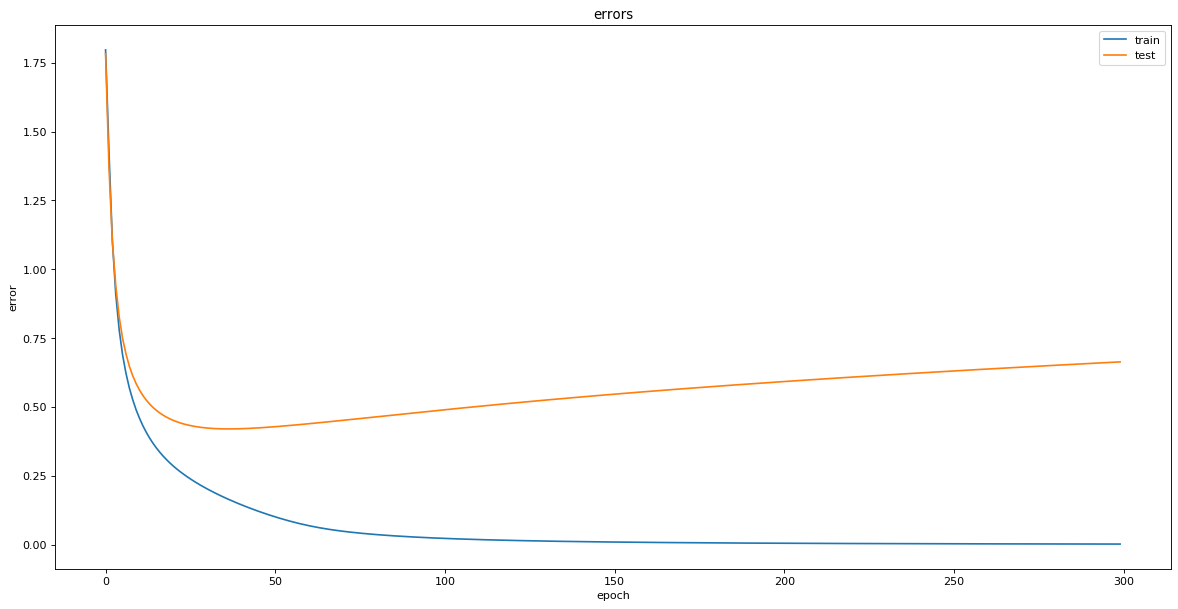

In [9]:
plot_train_test([train_log, test_log], 'loss')

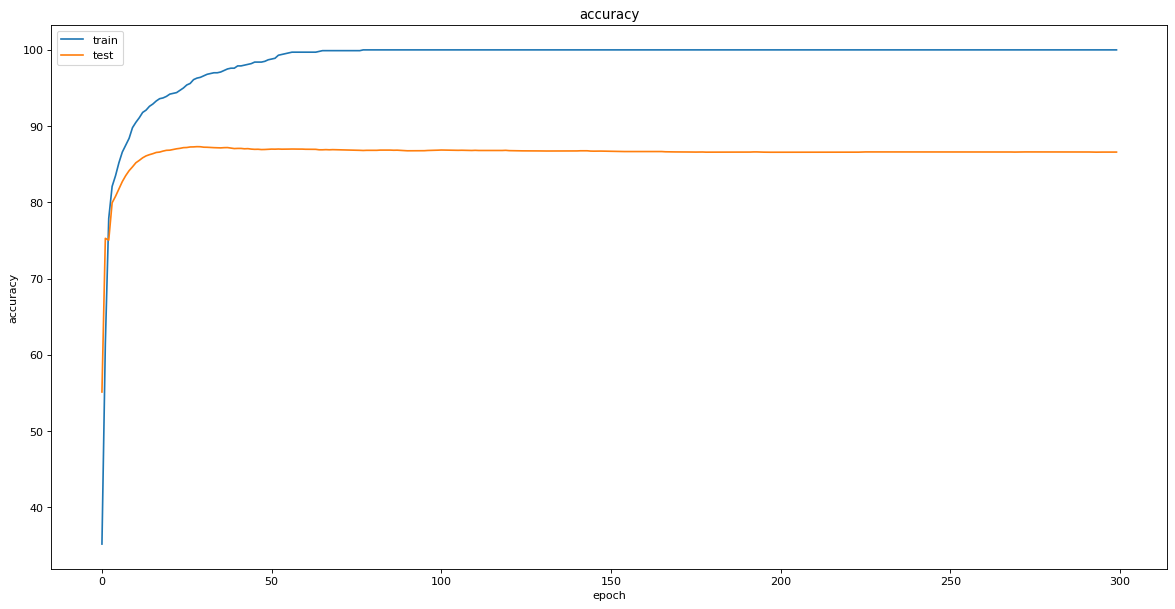

In [10]:
plot_train_test([train_log, test_log], 'accuracy')